# Gaussian Processes -- AIMS CDT 2020, Michaelmas Week 1
### Dominik Kloepfer

## Import Packages

In [1]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scipy

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [145]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [144]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from gp_methods import posterior_predictive_distr, neg_marg_log_likelihood
import cov_functions
import mean_functions
import visualisations


## Import Data

In [4]:
with open('sotonmet.txt') as input:
    raw_data = [line.strip().split(',') for line in input] #load data into list

known_raw_data = []
missing_raw_data = []

first_timestamp = np.datetime64(raw_data[1][2])

for datapoint in raw_data[1:]:

    # convert datetimes into numpy datetime objects, then calculate time difference to first measurement, then calculate in hours
    datapoint[2] = (np.datetime64(datapoint[2]) - first_timestamp) / np.timedelta64(1, 'h')


    # convert numbers into np.floats
    datapoint[1] = np.float(datapoint[1])
    for i in range(3, len(datapoint)):
        if datapoint[i]:
            datapoint[i] = np.float(datapoint[i])
        else:
            datapoint[i] = np.nan

    # split datapoints into known datapoints and datapoints with missing data
    if np.nan in datapoint:
        missing_raw_data.append(datapoint[2:]) # remove redundant first two columns
    else:
        known_raw_data.append(datapoint[2:]) # remove redundant first two columns

In [5]:
known_data = np.array(known_raw_data)
missing_data = np.array(missing_raw_data)

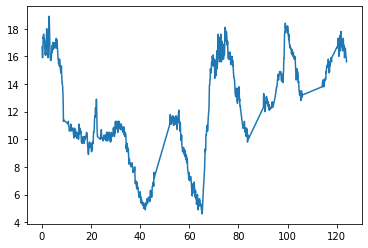

In [51]:
plt.plot(known_data[:, 0], known_data[:, 2])


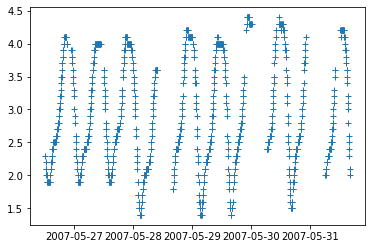

In [10]:
plt.plot(known_data[:, 0], known_data[:, 3], '+')

## Gaussian Process with Fixed Mean and Variance Functions

### Air Temperature

Define necessary variables and functions:

In [153]:
air_temp_mean_f = lambda X: mean_functions.const(X, np.array([np.mean(known_data[:, 2])])) # use mean of known air temperature as prior constant mean

alpha = np.std(known_data[:, 2]) # this parameter pretty much gives the standard deviation of each single point, so set it to the overall standard deviation
beta = 8 # after eight hours the time of day has changed significantly and there should not be too much correlation anymore -- might make this lower
air_temp_cov_f = lambda X, Y: cov_functions.matern_half(X, Y, np.array([alpha, beta])) # use Matern kernel as covaiance function for Air temperature

X = np.expand_dims(known_data[:, 0], axis=1)
y = np.expand_dims(known_data[:, 2], axis=1)
target_noise = np.zeros_like(y)
jitter = 1e-4

X_star = np.linspace(known_data[0, 0], known_data[-1, 0], num=10000)
X_star = np.expand_dims(X_star, axis=1)


Calculate posterior distribution:

In [154]:
mean_star, cov_star = posterior_predictive_distr(X, y, target_noise, X_star, air_temp_mean_f, air_temp_cov_f, jitter)

Visualise:

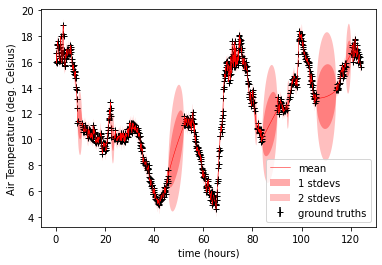

In [155]:
visualisations.plot_true_data(X, y, "time (hours)", "Air Temperature (deg. Celsius)", np.squeeze(target_noise))
visualisations.plot_mean(X_star, mean_star)
visualisations.plot_uncertainty(X_star[:, 0], mean_star, cov_star, [1, 2])

### Tide Height

Define necessary variables and functions:

In [163]:
tide_height_mean_f = lambda X: mean_functions.const(X, np.array([np.mean(known_data[:, 2])])) # use mean of known tide height as prior constant mean

alpha = np.sqrt(np.std(known_data[:, 3])) # this parameter pretty much gives the standard deviation of each single point, so set it to the overall standard deviation
beta = 4 # after four hours the tide has changed significantly and there should not be too much correlation anymore -- might make this lower
period = 12 # tide period is 12 hours
tide_height_cov_f = lambda X, Y: np.multiply(cov_functions.periodic(X, Y, np.array([alpha, beta, period])), cov_functions.rbf(X, Y, np.array([alpha, beta]))) # use locally periodic kernel as covaiance function for Air temperature

X = np.expand_dims(known_data[:, 0], axis=1)
y = np.expand_dims(known_data[:, 3], axis=1)
target_noise = 0.1*np.ones_like(y)
jitter = 1e-5

X_star = np.linspace(known_data[0, 0], known_data[-1, 0], num=10000)
X_star = np.expand_dims(X_star, axis=1)


Calculate posterior distribution:

In [164]:
mean_star, cov_star = posterior_predictive_distr(X, y, target_noise, X_star, tide_height_mean_f, tide_height_cov_f, jitter)

Visualise:

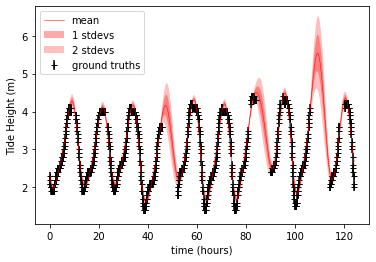

In [165]:
visualisations.plot_true_data(X, y, "time (hours)", "Tide Height (m)", np.squeeze(target_noise))
visualisations.plot_mean(X_star, mean_star)
visualisations.plot_uncertainty(X_star[:, 0], mean_star, cov_star, [1, 2])

## Maximum Likelihood Estimation of Hyperparameters

### Air Temperature

In [169]:
# arguments for gp_log_likelihood
initial_guess = np.array([np.mean(known_data[:, 2]), np.std(known_data[:, 2]), 8]) # use fixed from above
n_mean_f_params = 1
mean_f = mean_functions.const
cov_f = cov_functions.matern_half
X = np.expand_dims(known_data[:, 0], axis=1)
y = np.expand_dims(known_data[:, 3], axis=1)
target_noise = 0.1*np.ones_like(y)
jitter = 1e-5

X_star = np.linspace(known_data[0, 0], known_data[-1, 0], num=10000)
X_star = np.expand_dims(X_star, axis=1)



In [168]:
best_params = minimize(neg_marg_log_likelihood, initial_guess, args=(n_mean_f_params, mean_f, cov_f, X, y, target_noise, jitter), options={'disp': True})

NameError: name 'neg_marg_log_likelihood' is not defined

Compute GP with best parameters

In [113]:
best_mean_f = lambda X: mean_f(X, best_params[:n_mean_f_params])
best_cov_f = lambda X, Y: cov_f(X, Y, best_params[n_mean_f_params:]) 

best_mean_star, best_cov_star = posterior_predictive_distr(X, y, target_noise, X_star, best_mean_f, best_cov_f, jitter)

(1, 5)